In [61]:
import sys
sys.path.append('../../../')

In [62]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [63]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

In [64]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [65]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [66]:
sets_lengths = (0.5, 0.25, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [67]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [68]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

#### Results

In [69]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 355/355 [00:16<00:00, 21.08it/s]


In [70]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.60766476,
 'train_acc': 0.518666684627533,
 'val_acc': 0.48533332347869873,
 'epoch': 80,
 'model_class': 'fnn',
 'path_name': '4_[10_15]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_80',
 'train_rmse': 0.8679477710861024,
 'val_rmse': 0.9266426855410163,
 'test_rmse': 0.9106774035482232,
 'train_rmse_perc': 0.20963843,
 'val_rmse_perc': 0.22350323,
 'test_rmse_perc': 0.21673168,
 'train_mcc': 0.377102392635433,
 'val_mcc': 0.34588200169236233,
 'test_mcc': 0.4015125666653856,
 'test_acc': 0.527999997138977,
 'train_mae_perc': 0.1687414,
 'val_mae_perc': 0.17908248,
 'test_mae_perc': 0.17096114}

In [71]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6029622,
 'train_acc': 0.5026666522026062,
 'val_acc': 0.5013333559036255,
 'epoch': 90,
 'model_class': 'fnn',
 'path_name': '4_[15_15]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_90',
 'train_rmse': 0.8390470785361213,
 'val_rmse': 0.8733078876700168,
 'test_rmse': 0.8778762251403479,
 'train_rmse_perc': 0.19916412,
 'val_rmse_perc': 0.20585807,
 'test_rmse_perc': 0.20125246,
 'train_mcc': 0.3591052327459498,
 'val_mcc': 0.37887717463284565,
 'test_mcc': 0.348252440498284,
 'test_acc': 0.4933333396911621,
 'train_mae_perc': 0.16218585,
 'val_mae_perc': 0.16622958,
 'test_mae_perc': 0.1621564}

In [72]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6029622,
 'train_acc': 0.5026666522026062,
 'val_acc': 0.5013333559036255,
 'epoch': 90,
 'model_class': 'fnn',
 'path_name': '4_[15_15]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_90',
 'train_rmse': 0.8390470785361213,
 'val_rmse': 0.8733078876700168,
 'test_rmse': 0.8778762251403479,
 'train_rmse_perc': 0.19916412,
 'val_rmse_perc': 0.20585807,
 'test_rmse_perc': 0.20125246,
 'train_mcc': 0.3591052327459498,
 'val_mcc': 0.37887717463284565,
 'test_mcc': 0.348252440498284,
 'test_acc': 0.4933333396911621,
 'train_mae_perc': 0.16218585,
 'val_mae_perc': 0.16622958,
 'test_mae_perc': 0.1621564}

In [73]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 355/355 [00:00<00:00, 5835.26it/s]


In [74]:
cm = all[sort_idx[0]]['test_cm'][0]

In [75]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

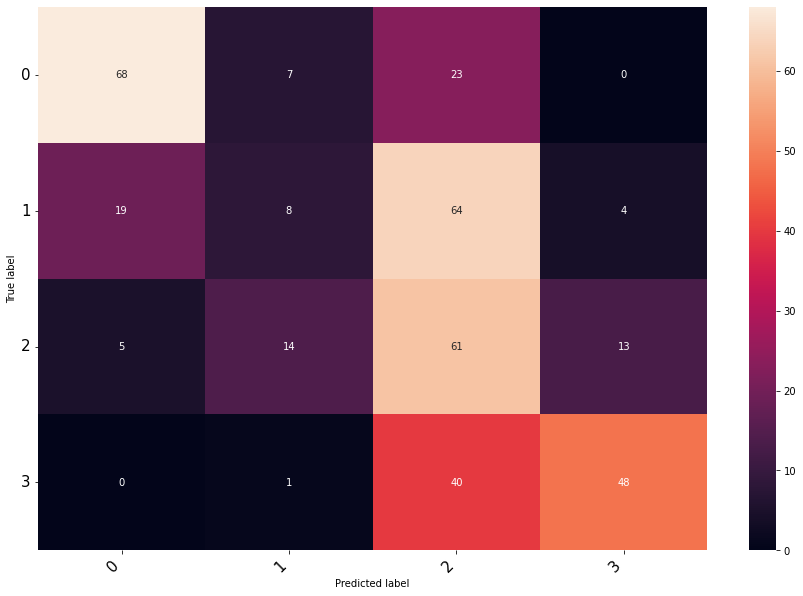

In [76]:
cm.visualize()

In [77]:
cm.class_accuracy

tensor([0.6939, 0.0842, 0.6559, 0.5393])

In [78]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.19759203, 0.23075071, 0.17997, 0.19231667]

In [79]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.14557984, 0.20655711, 0.13938276, 0.15681235]

### GCN

In [80]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [81]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [82]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 792/792 [00:46<00:00, 16.99it/s]


In [83]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.7441219,
 'train_acc': 0.42533332109451294,
 'val_acc': 0.40799999237060547,
 'epoch': 99,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_None_0.2_0.1_adamw_max_val_mcc_True_mse_True_0',
 'train_rmse': 0.920869154657707,
 'val_rmse': 0.8839306156782518,
 'test_rmse': 0.920869154657707,
 'train_rmse_perc': 0.23325546,
 'val_rmse_perc': 0.22078858,
 'test_rmse_perc': 0.23708498,
 'train_mcc': 0.2903318448923539,
 'val_mcc': 0.29377765843485065,
 'test_mcc': 0.3045443958942615,
 'test_acc': 0.4399999976158142,
 'train_mae_perc': 0.18532622,
 'val_mae_perc': 0.18336678,
 'test_mae_perc': 0.18416801}

In [84]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.696877,
 'train_acc': 0.4386666715145111,
 'val_acc': 0.41866666078567505,
 'epoch': 40,
 'model_class': 'gcn',
 'path_name': '4_[15_15_15]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_True_mse_True_0_40',
 'train_rmse': 0.886190348251059,
 'val_rmse': 0.8929352346801717,
 'test_rmse': 0.9465727652959386,
 'train_rmse_perc': 0.21433544,
 'val_rmse_perc': 0.21483317,
 'test_rmse_perc': 0.22284596,
 'train_mcc': 0.33956954435422126,
 'val_mcc': 0.3462933318064178,
 'test_mcc': 0.2952985103828882,
 'test_acc': 0.41866666078567505,
 'train_mae_perc': 0.17771277,
 'val_mae_perc': 0.1801707,
 'test_mae_perc': 0.17959684}

In [85]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.69709474,
 'train_acc': 0.437333345413208,
 'val_acc': 0.41066667437553406,
 'epoch': 70,
 'model_class': 'gcn',
 'path_name': '4_[10_15_20]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_True_mse_True_0_70',
 'train_rmse': 0.8594571930391104,
 'val_rmse': 0.8702490065109717,
 'test_rmse': 0.8763560920082658,
 'train_rmse_perc': 0.21515849,
 'val_rmse_perc': 0.21484971,
 'test_rmse_perc': 0.21523412,
 'train_mcc': 0.32454621768837044,
 'val_mcc': 0.30867793350504436,
 'test_mcc': 0.31093078697560295,
 'test_acc': 0.4346666634082794,
 'train_mae_perc': 0.18206176,
 'val_mae_perc': 0.18160044,
 'test_mae_perc': 0.17678109}

In [86]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 792/792 [00:00<00:00, 22059.31it/s]


### GraphSAGE

In [87]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [88]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [89]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [08:10<00:00,  2.42it/s]


True

In [90]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.03548379,
 'train_acc': 0.9440000057220459,
 'val_acc': 0.8533333539962769,
 'epoch': 85,
 'model_class': 'sage',
 'path_name': '4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0',
 'train_rmse': 0.23664319132398465,
 'val_rmse': 0.39327683210007003,
 'test_rmse': 0.4788875998951459,
 'train_rmse_perc': 0.083603136,
 'val_rmse_perc': 0.09266845,
 'test_rmse_perc': 0.11741615,
 'train_mcc': 0.9271670528371249,
 'val_mcc': 0.8100436775296593,
 'test_mcc': 0.7883552223799615,
 'test_acc': 0.8373333215713501,
 'train_mae_perc': 0.0675181

In [91]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.2135972,
 'train_acc': 0.846666693687439,
 'val_acc': 0.8293333053588867,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[25_25_25]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0.2_60',
 'train_rmse': 0.4016632088371218,
 'val_rmse': 0.4226897995772629,
 'test_rmse': 0.518973345494095,
 'train_rmse_perc': 0.08444247,
 'val_rmse_perc': 0.08873381,
 'test_rmse_perc': 0.101872586,
 'train_mcc': 0.8010311846802427,
 'val_mcc': 0.776174320013833,
 'test_mcc': 0.7363397951796167,
 'test_acc': 0.800000011920929,
 'train_mae_perc': 0.0653368

In [92]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.2135972,
 'train_acc': 0.846666693687439,
 'val_acc': 0.8293333053588867,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[25_25_25]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0.2_60',
 'train_rmse': 0.4016632088371218,
 'val_rmse': 0.4226897995772629,
 'test_rmse': 0.518973345494095,
 'train_rmse_perc': 0.08444247,
 'val_rmse_perc': 0.08873381,
 'test_rmse_perc': 0.101872586,
 'train_mcc': 0.8010311846802427,
 'val_mcc': 0.776174320013833,
 'test_mcc': 0.7363397951796167,
 'test_acc': 0.800000011920929,
 'train_mae_perc': 0.0653368

In [93]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 20189.52it/s]


#### cm

In [94]:
cm = all[sort_idx[0]]['test_cm'][0]

In [95]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

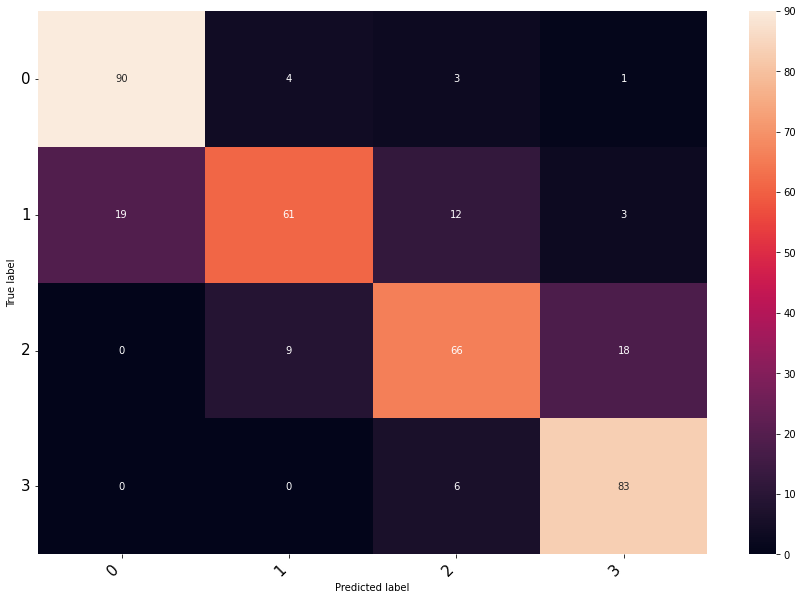

In [96]:
cm.visualize()

In [97]:
cm.class_accuracy

tensor([0.9184, 0.6421, 0.7097, 0.9326])

In [98]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.10368276, 0.12738834, 0.08982088, 0.07834689]

In [99]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.07162277, 0.0944858, 0.06541928, 0.050005227]

#### GraphSAGE Base_n

In [100]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [101]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            base_n=True,
        )

##### Results

In [102]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 1188/1188 [07:45<00:00,  2.55it/s]


True

In [103]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.1665002,
 'train_acc': 0.7360000014305115,
 'val_acc': 0.6746666431427002,
 'epoch': 40,
 'model_class': 'sage',
 'path_name': '4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_40',
 'train_rmse': 0.5403702434442518,
 'val_rmse': 0.6408327915038888,
 'test_rmse': 0.6239658110292048,
 'train_rmse_perc': 0.11866944,
 'val_rmse_perc': 0.13427174,
 'test_rmse_perc': 0.124593645,
 'train_mcc': 0.653793595093866,
 'val_mcc': 0.5760529939787639,
 'test_mcc': 0.6061775912188782,
 'test_acc': 0.6959999799728394,
 'train_mae_perc': 0.09337496

In [104]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.07471406,
 'train_acc': 0.690666675567627,
 'val_acc': 0.6959999799728394,
 'epoch': 50,
 'model_class': 'sage',
 'path_name': '4_[25_25_25]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_50',
 'train_rmse': 0.5561774297230456,
 'val_rmse': 0.565685424949238,
 'test_rmse': 0.6175219294351686,
 'train_rmse_perc': 0.11661998,
 'val_rmse_perc': 0.115901634,
 'test_rmse_perc': 0.12932338,
 'train_mcc': 0.6152784040538454,
 'val_mcc': 0.6199061800906623,
 'test_mcc': 0.54632067484645,
 'test_acc': 0.6426666378974915,
 'train_mae_perc': 0.094261356,

In [105]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.11965305,
 'train_acc': 0.7133333086967468,
 'val_acc': 0.6613333225250244,
 'epoch': 50,
 'model_class': 'sage',
 'path_name': '4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_50',
 'train_rmse': 0.5391351098441528,
 'val_rmse': 0.6131883886702356,
 'test_rmse': 0.5887840577551898,
 'train_rmse_perc': 0.111910485,
 'val_rmse_perc': 0.12242107,
 'test_rmse_perc': 0.11715383,
 'train_mcc': 0.6334149828798754,
 'val_mcc': 0.5642572101992117,
 'test_mcc': 0.5962156421323229,
 'test_acc': 0.6853333115577698,
 'train_mae_perc': 0.089589

In [106]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1188/1188 [00:00<00:00, 22908.00it/s]


##### cm

In [107]:
cm = all[sort_idx[0]]['test_cm'][0]

In [108]:
(cm.labels==0).sum()

tensor(98)

In [109]:
cm.pseudo_perc.max()

tensor(0.9964)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

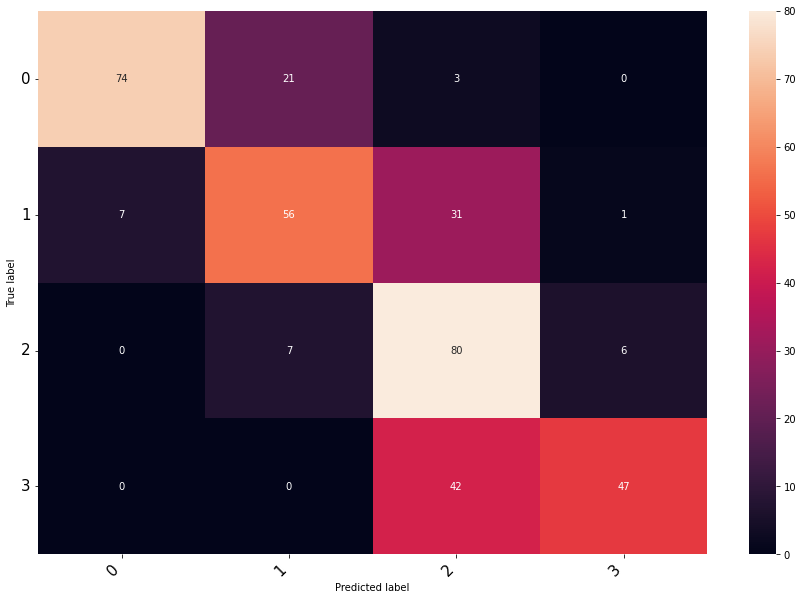

In [110]:
cm.visualize()

In [111]:
cm.class_accuracy

tensor([0.7551, 0.5895, 0.8602, 0.5281])

In [112]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.10647562, 0.12086752, 0.096731305, 0.14133412]

In [113]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.07370404, 0.09579116, 0.0706343, 0.1244345]

### GAT

In [114]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [115]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [116]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 3168/3168 [02:51<00:00, 18.50it/s]


In [117]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.727152,
 'train_acc': 0.6506666541099548,
 'val_acc': 0.6666666865348816,
 'epoch': 92,
 'model_class': 'gat',
 'path_name': '4_[25]_1_[4_4]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2',
 'train_rmse': 0.7220341635499897,
 'val_rmse': 0.7155417527999327,
 'test_rmse': 0.7192588778272627,
 'train_rmse_perc': 0.16651614,
 'val_rmse_perc': 0.16130975,
 'test_rmse_perc': 0.16222064,
 'train_mcc': 0.5342425173277258,
 'val_mcc': 0.5559252873683139,
 'test_mcc': 0.48215085899881266,
 'test_acc': 0.6106666922569

In [118]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.6395497,
 'train_acc': 0.6146666407585144,
 'val_acc': 0.6159999966621399,
 'epoch': 94,
 'model_class': 'gat',
 'path_name': '4_[20_20]_1_[4_4]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0',
 'train_rmse': 0.6792152334373349,
 'val_rmse': 0.7099295739719539,
 'test_rmse': 0.758946638440411,
 'train_rmse_perc': 0.15515137,
 'val_rmse_perc': 0.15183406,
 'test_rmse_perc': 0.17462067,
 'train_mcc': 0.49337266636054344,
 'val_mcc': 0.4936912489840967,
 'test_mcc': 0.4263995596825395,
 'test_acc': 0.5600000023

In [119]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.727152,
 'train_acc': 0.6506666541099548,
 'val_acc': 0.6666666865348816,
 'epoch': 92,
 'model_class': 'gat',
 'path_name': '4_[25]_1_[4_4]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0.2',
 'train_rmse': 0.7220341635499897,
 'val_rmse': 0.7155417527999327,
 'test_rmse': 0.7192588778272627,
 'train_rmse_perc': 0.16651614,
 'val_rmse_perc': 0.16130975,
 'test_rmse_perc': 0.16222064,
 'train_mcc': 0.5342425173277258,
 'val_mcc': 0.5559252873683139,
 'test_mcc': 0.48215085899881266,
 'test_acc': 0.6106666922569

In [120]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3168/3168 [00:00<00:00, 20493.44it/s]
